**Calculate the average coating coverage from a SEM (Scanning Electron Microscope) image
Graphene oxide onto a Titanium Dioxide thin film**

You can try this notebook on

- data/TiO2 450 1h 0.01 GO07.png
- data/TiO2 450 1h 0.01 GO08.png

**Import libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import AnchoredText
from scipy.signal import find_peaks
from skimage import color, filters, io, measure, morphology

**Load the image**

C:\Python37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  after removing the cwd from sys.path.


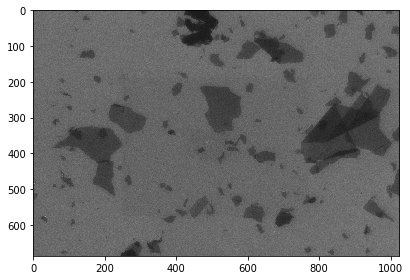

In [2]:
f_name = "data/TiO2 450 1h 0.01 GO08.png"
im = io.imread(f_name)
io.imshow(im)
gray_image = color.rgb2gray(im)
blurred_image = filters.gaussian(gray_image, sigma=1.0)

**Visualize the gray level histogram**

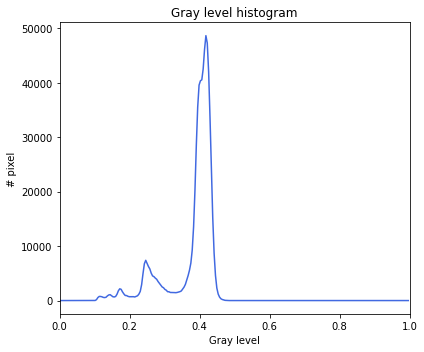

In [3]:
histogram, bin_edges = np.histogram(blurred_image, bins=256, range=(0.0, 1.0))
x = bin_edges[0:-1]

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(x, histogram, c="royalblue")

ax.set_title("Gray level histogram")
ax.set_xlabel("Gray level")
ax.set_ylabel("# pixel")
ax.set_xlim(0, 1.0)

fig.tight_layout()
plt.show()

If the background gray level is constant throughout the image, and if the foreground objects have a comparable contrast that is above the background, then a global threshold value can be used to segment the entire image.

The broader peak around 0.4 corresponds to the substrate. The smaller peaks near zero is what we are after: the GO sheets. A reasonable choice thus might be to leave pixels below the substrate peak.

**Use the find_peaks function from scipy to find the local minima.**

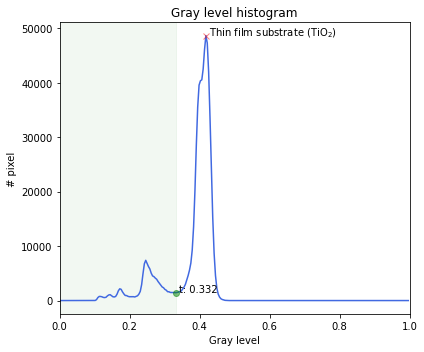

In [4]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(x, histogram, c="royalblue")

max_, _ = find_peaks(histogram)
min_, _ = find_peaks(histogram*-1)
t_index = np.where(histogram[max_]==histogram[max_].max())[0][0]

# max
X_ = x[max_][t_index]
Y_ = histogram[max_][t_index]
ax.plot(X_, Y_, marker="x", c="r", alpha=0.5)
ax.text(x=X_ + 0.01, y=Y_, s="Thin film substrate (TiO$_2$)")

# local min
X = x[min_][t_index-1]
Y = histogram[min_][t_index-1]
ax.plot(X, Y, marker="o", c="g", alpha=0.5)
ax.text(x=X + 0.01, y=Y, s="t: " + str(X.round(3)))

ax.axvspan(0, X, color="g", alpha=0.05)

ax.set_title("Gray level histogram")
ax.set_xlabel("Gray level")
ax.set_ylabel("# pixel")
ax.set_xlim(0, 1.0)

fig.tight_layout()
plt.show()

**Generate a binary image based on threshold**

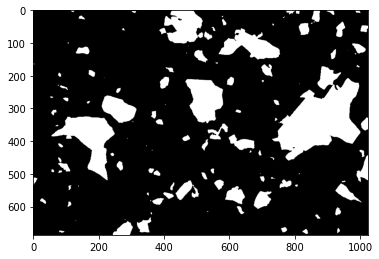

In [5]:
t = X
binary_mask = blurred_image < t
fig, ax = plt.subplots(figsize=(6,5))
ax.imshow(binary_mask, cmap="gray")
plt.show()

**Binary image, post-process the binary mask and compute labels**

In [6]:
threshold = filters.threshold_otsu(binary_mask)
mask = binary_mask > threshold
mask = morphology.remove_small_objects(mask, 50)
mask = morphology.remove_small_holes(mask, 50)
labels = measure.label(mask)
props = measure.regionprops(labels, binary_mask)

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


**Getting the areas of the sheets**

In [7]:
areas = [props[index]["area"] for index in range(1, labels.max())]
areas = np.array(areas)
print("Area of the sheets is", areas.sum(), "pixels")

Area of the sheets is 120940 pixels


In [8]:
# function to calculate the coverage %
def get_coverage(image, areas):
      im_w, im_h = len(image), len(image[1])
      im_area = im_w*im_h
      print(f"Image area (w: {im_w}, h: {im_h}) is", round(im_area,2), "pixels")
      sheets_area = areas.sum()
      coverage = round(sheets_area/im_area*100, 2)
      print("GO sheet covers", f"{coverage}% of the area")
      return coverage

In [9]:
coverage = get_coverage(binary_mask, areas)

Image area (w: 687, h: 1024) is 703488 pixels
GO sheet covers 17.19% of the area


**Show the result**

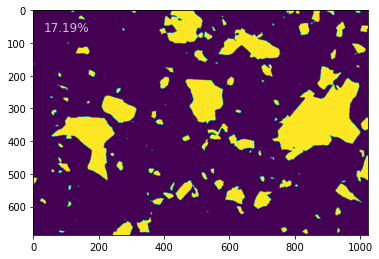

In [10]:
fig, ax = plt.subplots(figsize=(6,5))
at = AnchoredText(f"{coverage}%",
                  prop=dict(size=12, color="white", alpha=0.75),
                  frameon=False,
                  loc="upper left")
ax.add_artist(at)
ax.imshow(binary_mask, cmap="viridis")
plt.show()